In [1]:
# importing necessary libraries

import  pandas              as pd
import  numpy               as np
import  seaborn             as sns
import  matplotlib.pyplot   as plt 

from    sklearn.metrics             import mutual_info_score
from    sklearn.preprocessing       import OneHotEncoder
from    sklearn.base                import BaseEstimator, TransformerMixin
from    sklearn.pipeline            import Pipeline
from    sklearn.preprocessing       import StandardScaler
from    sklearn.compose             import ColumnTransformer

In [91]:
import  mlflow
from    sklearn.model_selection     import cross_val_score
from    sklearn.linear_model        import LogisticRegression
from    sklearn.tree                import DecisionTreeClassifier
from    sklearn.ensemble            import RandomForestClassifier
from    xgboost                     import XGBClassifier
from    sklearn.metrics             import f1_score

from    hyperopt                    import STATUS_OK, Trials, fmin, hp, tpe

### 1. Bigger Picture

`Framing Problem` 

Based on aspects of building location and construction, the goal of the project is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal. We're trying to predict the ordinal variable damage_grade, which represents a level of damage to the building that was hit by the earthquake. Hence this will be a multi-class classification problem

`Performance Metric Definition`

This data is provided as part of a DrivenData competition and the organizers have defined the required performance metric to be micro averaged F1 score as this is a multi class classification problem

`Assumptions made`

*  It is specified that categorical variables have been obfuscated random lowercase ascii characters. I assume that the appearance of the same character in distinct columns does not imply the same original value

`Defining Baseline`

The benchmark for submissions has been defined as part of competition to be **F1 score = 0.5815**

### 2. Getting Data and generating insights

In [140]:
#reading data from downloaded files
df_train            = pd.read_csv('data/train_values.csv',index_col='building_id')
y_train_df          = pd.read_csv('data/train_labels.csv',index_col='building_id')
df_test             = pd.read_csv('data/test_values.csv' ,index_col='building_id')
submission_format   = pd.read_csv('data/submission_format.csv', index_col='building_id') #submission format specified by competition
#Note: As this data is part of a competition, the test labels are not made public. 
#Hence the performance on test data can only be evaluated after submission

#converting training labels into an array
y_train     = y_train_df.values.ravel()
y_train     = list(map(lambda x: x - 1, y_train)) #xgboost needs labels to start from zero

In [4]:
df_train.shape

(260601, 38)

In [5]:
#checking missing values for features
df_train.isnull().sum()

geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engine

In [6]:
print("dtypes present: ",set(df_train.dtypes))
print("number of int64 features: ",len(df_train.select_dtypes('int64').columns))
print("number of categorical features: ",len(df_train.select_dtypes('O').columns))

dtypes present:  {dtype('int64'), dtype('O')}
number of int64 features:  30
number of categorical features:  8


In [7]:
#understanding data structure
df_train.select_dtypes('int64').T.head(n=39)

building_id,802906,28830,94947,590882,201944,333020,728451,475515,441126,989500,...,560805,207683,226421,159555,827012,688636,669485,602512,151409,747594
geo_level_1_id,6,8,21,22,11,8,9,20,0,26,...,20,10,8,27,8,25,17,17,26,21
geo_level_2_id,487,900,363,418,131,558,475,323,757,886,...,368,1382,767,181,268,1335,715,51,39,9
geo_level_3_id,12198,2812,8973,10694,1488,6089,12066,12236,7219,994,...,5980,1903,8613,1537,4718,1621,2060,8163,1851,9101
count_floors_pre_eq,2,2,2,2,3,2,2,2,2,1,...,1,2,2,6,2,1,2,3,2,3
age,30,10,10,10,30,10,25,0,15,0,...,25,25,5,0,20,55,0,55,10,10
area_percentage,6,8,5,6,8,9,3,8,8,13,...,5,5,13,13,8,6,6,6,14,7
height_percentage,5,7,5,5,9,5,4,6,6,4,...,3,5,5,12,5,3,5,7,6,6
has_superstructure_adobe_mud,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
has_superstructure_mud_mortar_stone,1,1,1,1,0,1,1,0,1,0,...,1,1,1,0,1,1,1,1,0,1
has_superstructure_stone_flag,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#understanding data structure
df_train.select_dtypes('O').T.head(n=39)

building_id,802906,28830,94947,590882,201944,333020,728451,475515,441126,989500,...,560805,207683,226421,159555,827012,688636,669485,602512,151409,747594
land_surface_condition,t,o,t,t,t,t,n,t,t,t,...,n,t,t,t,t,n,t,t,t,n
foundation_type,r,r,r,r,r,r,r,w,r,i,...,r,r,r,r,r,r,r,r,r,r
roof_type,n,n,n,n,n,n,n,q,q,n,...,n,n,n,n,n,n,n,q,x,n
ground_floor_type,f,x,f,f,f,f,x,v,f,v,...,f,f,f,f,f,f,f,f,v,f
other_floor_type,q,q,x,x,x,q,q,x,q,j,...,j,q,q,x,q,j,q,q,s,q
position,t,s,t,s,s,s,s,s,s,s,...,s,s,s,j,s,s,s,s,j,j
plan_configuration,d,d,d,d,d,d,d,u,d,d,...,d,d,d,d,d,q,d,d,d,d
legal_ownership_status,v,v,v,v,v,v,v,v,v,v,...,v,v,v,v,v,v,v,v,v,v


In [9]:
#checking the distribution of numerical features which are not binary flags or geo labels
df_train[['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']].describe()

,age,area_percentage,height_percentage,count_floors_pre_eq,count_families
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,26.535029,8.018051,5.434365,2.129723,0.983949
std,73.565937,4.392231,1.918418,0.727665,0.418389
min,0.000000,1.000000,2.000000,1.000000,0.000000
25%,10.000000,5.000000,4.000000,2.000000,1.000000
50%,15.000000,7.000000,5.000000,2.000000,1.000000
75%,30.000000,9.000000,6.000000,2.000000,1.000000
max,995.000000,100.000000,32.000000,9.000000,9.000000


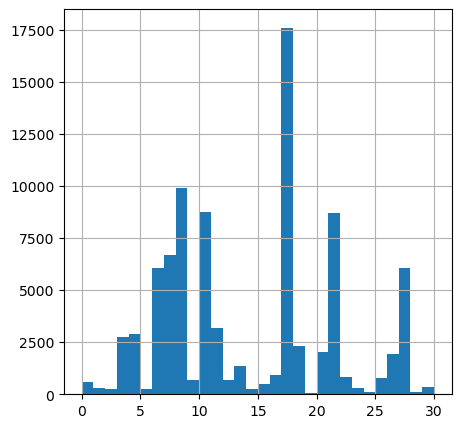

In [10]:
df_joint_train = df_train.join(y_train_df)
df_joint_train[df_joint_train['damage_grade']==3]['geo_level_1_id'].hist(bins=30, figsize=(5,5))
plt.show()

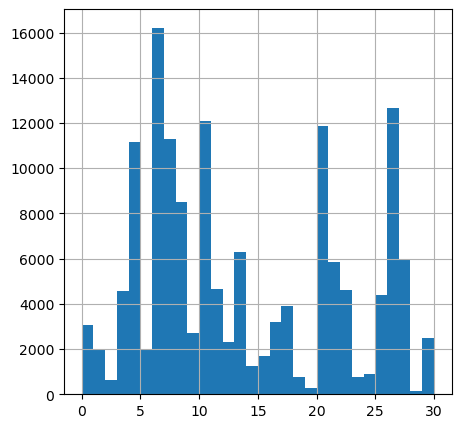

In [11]:
df_joint_train[df_joint_train['damage_grade']==2]['geo_level_1_id'].hist(bins=30, figsize=(5,5))
plt.show()

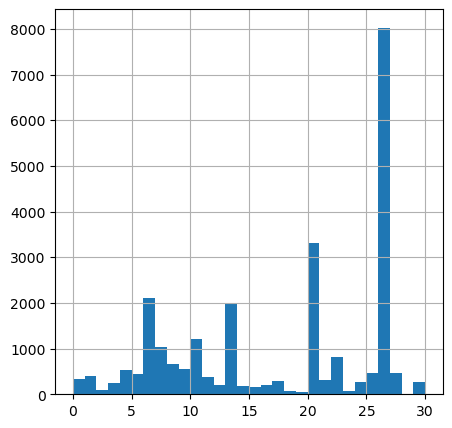

In [12]:
df_joint_train[df_joint_train['damage_grade']==1]['geo_level_1_id'].hist(bins=30, figsize=(5,5))
plt.show()

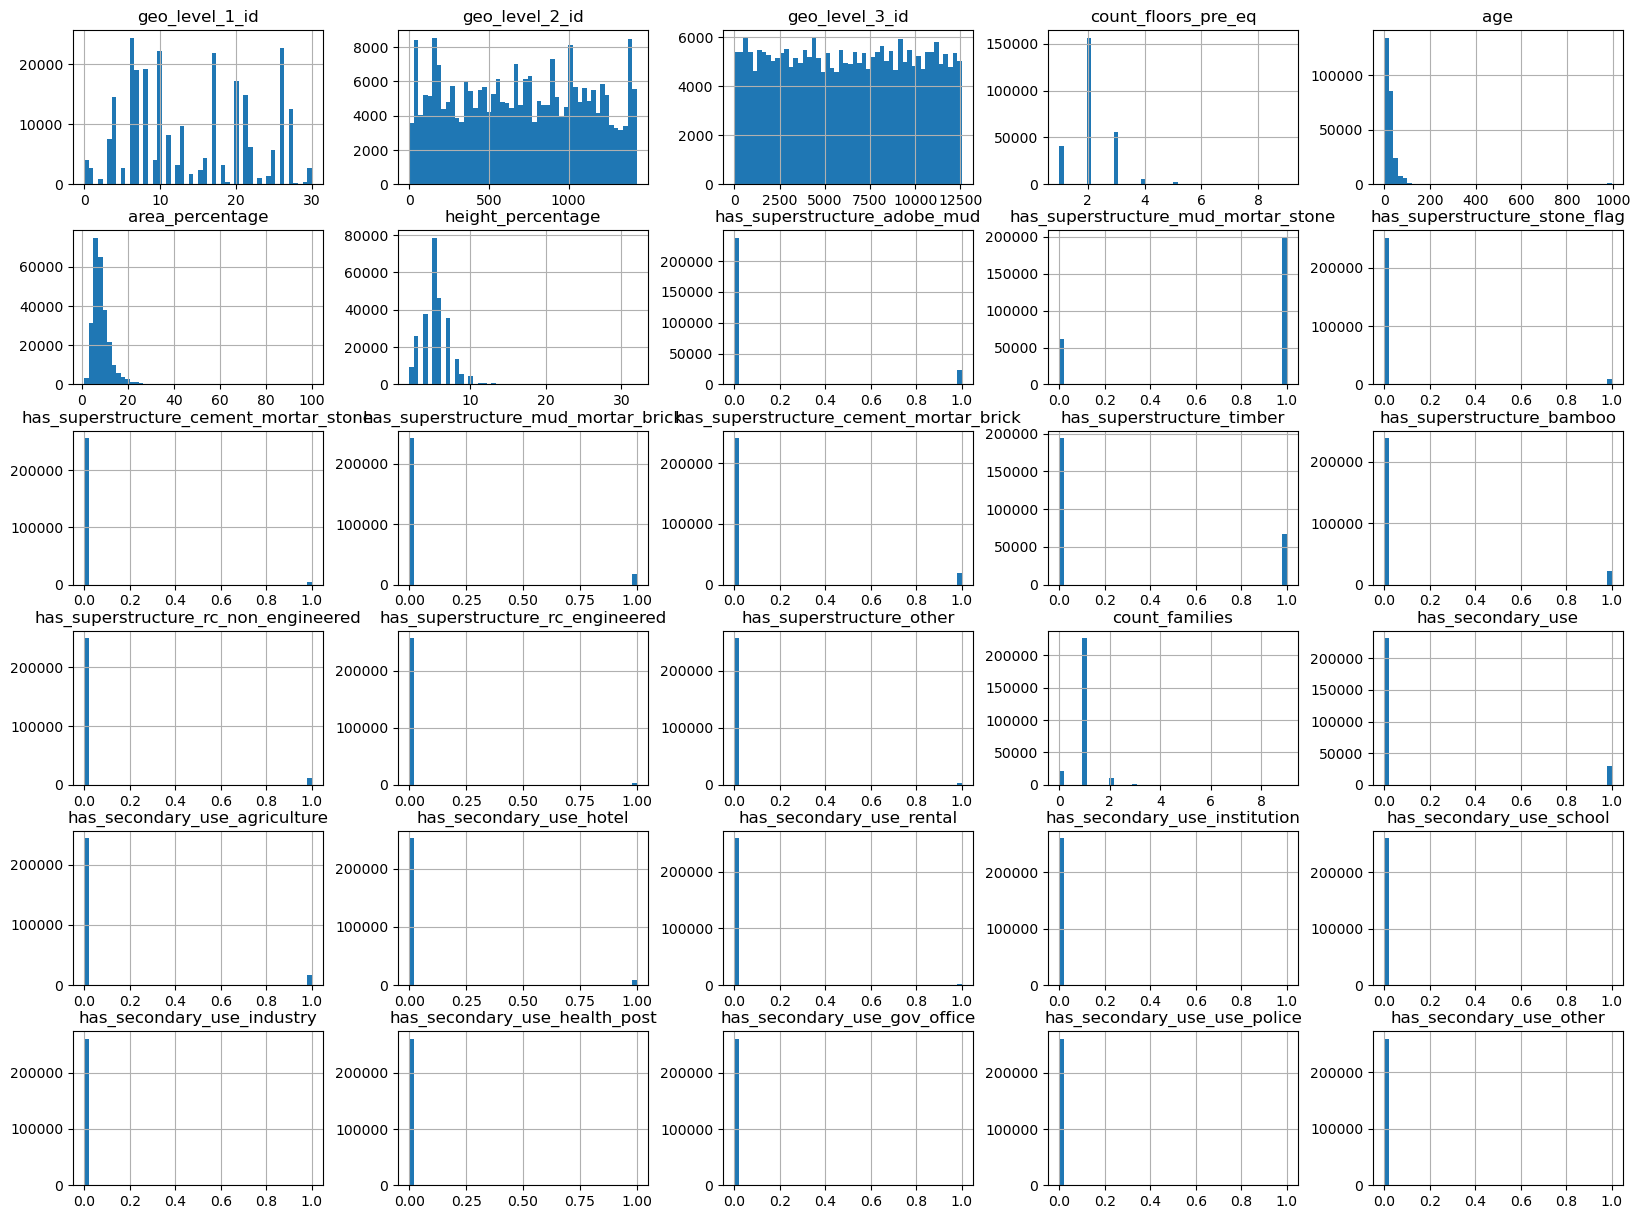

In [13]:
df_train.hist(bins=50, figsize=(20,15))
plt.show()

In [14]:
#percentage of buildings older than 200 years
print((df_train[df_train['age']>200].shape[0]/df_train.shape[0])*100)
#percentage of buildings older than 200 years
print((df_train[df_train['area_percentage']>50].shape[0]/df_train.shape[0])*100)

0.5333824505661913
0.064850096507688


In [15]:
#seperating out features
cat_features    = list(df_train.select_dtypes('O').columns)
int_features    = list(df_train.select_dtypes('int64').columns) 
num_features    = ['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']
numlab_features = [x for x in int_features if x not in num_features]

In [16]:
#converting numerical features to categorical and calculating mutual info score
qage = pd.qcut(df_train.age, q=10, duplicates='drop')
qarea = pd.qcut(df_train.area_percentage, q=10, duplicates='drop')
qhgt = pd.qcut(df_train.height_percentage, q=10, duplicates='drop')
qflr = pd.qcut(df_train.count_floors_pre_eq, q=10, duplicates='drop')
qfam = pd.qcut(df_train.count_families, q=10, duplicates='drop')


In [17]:
#calculating new features
df_train['height_per_area']     = df_train['height_percentage']/df_train['area_percentage']
df_train['hpa_aged']            = df_train['height_per_area']*df_train['age']
df_train['floors_per_height']   = df_train['count_floors_pre_eq']/df_train['height_percentage']

qhpa = pd.qcut(df_train.height_per_area, q=10, duplicates='drop')
qhpag = pd.qcut(df_train.hpa_aged, q=10, duplicates='drop')
qfph = pd.qcut(df_train.floors_per_height, q=10, duplicates='drop')

engineered_features = ['height_per_area','hpa_aged','floors_per_height']

In [18]:
mis             = []
feature_list    = num_features+engineered_features+cat_features+numlab_features

for c in [qage, qarea, qhgt,qflr, qfam, qhpa, qhpag, qfph]:
    mis.append(mutual_info_score(y_train_df.damage_grade, c))

for c in cat_features+numlab_features:
    mis.append(mutual_info_score(y_train_df.damage_grade, df_train[f'{c}']))

In [19]:
mis_scores = pd.DataFrame({'feature'            :feature_list,
                           'mutual_info_score'  :mis})

mis_scores.sort_values(by='mutual_info_score', ascending=False).reset_index(drop=True)

,feature,mutual_info_score
0,geo_level_3_id,0.334123
1,geo_level_2_id,0.240002
2,geo_level_1_id,0.131877
3,foundation_type,0.071000
4,ground_floor_type,0.053564
5,has_superstructure_mud_mortar_stone,0.049215
6,other_floor_type,0.047697
7,roof_type,0.040643
8,hpa_aged,0.034240
9,has_superstructure_cement_mortar_brick,0.032731


<AxesSubplot:>

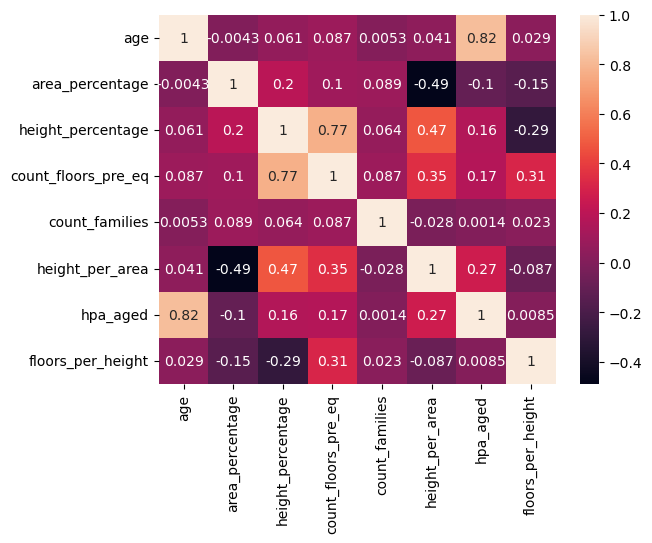

In [20]:
#checking the correlation between numerical features to identify any highly correlated ones

corr_matrix = df_train[num_features+engineered_features].corr()
sns.heatmap(corr_matrix,annot=True)

In [21]:
#lsit of features to be retained
mis_scores[mis_scores['mutual_info_score']>=0.01].sort_values(by='mutual_info_score', ascending=False).reset_index(drop=True)

,feature,mutual_info_score
0,geo_level_3_id,0.334123
1,geo_level_2_id,0.240002
2,geo_level_1_id,0.131877
3,foundation_type,0.071000
4,ground_floor_type,0.053564
5,has_superstructure_mud_mortar_stone,0.049215
6,other_floor_type,0.047697
7,roof_type,0.040643
8,hpa_aged,0.034240
9,has_superstructure_cement_mortar_brick,0.032731


`Insights`

* So we have 38 features: 30 numerical and 8 categorical
* On closer inspection most of the numerical features are binary flags
* Areas with geo_level_1_id centred around 17 suffred most damages. Areas with geo_ids less than 17 seems have suffered level 2 damages most and the ones with geo_ids greater suffred comparatively the least
* Most buildings were new/young 2 floor single family homes with small area
* Few of the numerical features: age, area_percentage, height_percentage seem to have longtail distribution
* None of the features have missing values
* Most buildings were made using Mud Mortar - Stone
* Outlier: >200 year old buildings (0.53%), >50 Area (0.064%)
* low mutual information score: land_surface_condition, position, plan_configuration, legal_ownership_status, count_floors_pre_eq, count_families, has_superstructure_adobe_mud, 'has_secondary.....', 'has_superstructure_other', 'has_superstructure_bamboo','has_superstructure_timber', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_adobe_mud'
* As expected geo location of the structure has the most influence on the amount of damage sustained by the structure
* Engineered features have more correlation than original features. However, age is highly correlated with hpa_aged and hence age should be removed

### 3. Prepare the Data for ML models

`Data Cleaning`

In [22]:
#making a clean copy of train data
df_train    = pd.read_csv('data/train_values.csv',index_col='building_id')

In [23]:
#getting a subset of data with only important features previously identified

important_features  = list(mis_scores[mis_scores['mutual_info_score']>=0.01]['feature']) 
retained_features   = [x for x in important_features if x not in engineered_features] #removing engineered features. This will be calculated later
retained_features   = [x for x in list(df_train.columns) if x in retained_features+['count_floors_pre_eq']] #reordering to original order and adding floor back

df_train_retained   = df_train[retained_features]

In [24]:
cat         = list(df_train_retained.select_dtypes('object'))
num         = ['age','area_percentage','height_percentage','count_floors_pre_eq']
num_flag    = [x for x in df_train_retained.select_dtypes('int64') if x not in num]

`Handling Categorical Features`

In [25]:
#one hot encoding the categorical features
df_train_cat = df_train[cat]

In [26]:
cat_encoder         = OneHotEncoder()
df_train_cat_1hot   = cat_encoder.fit_transform(df_train_cat)

In [27]:
df_train_cat_1hot.toarray().shape

(260601, 17)

In [28]:
cat_encoder.categories_

[array(['h', 'i', 'r', 'u', 'w'], dtype=object),
 array(['n', 'q', 'x'], dtype=object),
 array(['f', 'm', 'v', 'x', 'z'], dtype=object),
 array(['j', 'q', 's', 'x'], dtype=object)]

`Custom Transformers`

In [29]:
#custom transformer to engineer new feature
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, drop_age = True): 
        self.drop_age = drop_age
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        age_ix, area_ix, height_ix, floor_ix = 0, 1, 2, 3 #indexes of the features
        
        for index in (age_ix, area_ix, height_ix, floor_ix):
            X.iloc[:,index] = np.log1p(X.iloc[:,index]) #log transform
                
        X_arr               =   X.values
        height_per_area     =   X_arr[:, height_ix] / X_arr[:, area_ix]
        hpa_aged            =   (X_arr[:, height_ix] / X_arr[:, area_ix]) * X_arr[:, age_ix]
        floors_per_height   =   X_arr[:, floor_ix] / X_arr[:, height_ix]

        if self.drop_age:
            X_del = np.delete(X_arr,[floor_ix,age_ix],1)
            return np.c_[X_del, height_per_area, hpa_aged, floors_per_height]
        else:
            X_del = np.delete(X_arr,floor_ix,1)
            return np.c_[X_del, height_per_area, hpa_aged, floors_per_height]

attr_adder      = CombinedAttributesAdder(drop_age = True)
extra_attribs   = attr_adder.transform(df_train[num])

C:\Users\noelp\AppData\Local\Temp\ipykernel_19328\4212121113.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.iloc[:,index] = np.log1p(X.iloc[:,index]) #log transform


`Transformation Pipelines`

In [30]:
#defining the pipeline for numerical features
num_pipeline = Pipeline([
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()),
                        ])

In [31]:
df_train_num_tr = num_pipeline.fit_transform(df_train[num]) #no errors. yay!

C:\Users\noelp\AppData\Local\Temp\ipykernel_19328\4212121113.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.iloc[:,index] = np.log1p(X.iloc[:,index]) #log transform


In [32]:
df_train_num_tr.shape

(260601, 5)

In [33]:
#defining final tranformation pipeline

transform_pipeline = ColumnTransformer([('num_flag', 'passthrough', num_flag),
                                        ("num", num_pipeline, num),
                                        ("cat", OneHotEncoder(), cat),
                                        ], 
                                        remainder='drop')

In [34]:
X_train = transform_pipeline.fit_transform(df_train)
X_test  = transform_pipeline.transform(df_test)

In [35]:
X_train.shape #number of columns is as expected. perfect! 

(260601, 29)

In [36]:
X_test.shape

(86868, 29)

### 4. Select and Train a Model 

`Baseline experiments`

In [44]:
#setting up an MLflow experiment for baseline predictions without any tuning
mlflow.set_experiment('Baseline predictions')
mlflow.sklearn.autolog() #to log metrics automatically

In [82]:
for m in (LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, XGBClassifier): 
        with mlflow.start_run(run_name=f'{m.__name__}_baseline') as run:
                
                if m.__name__ == 'LogisticRegression':
                        model   = m(solver='liblinear')
                        f1_scores   = cross_val_score(model, X_train, y_train, scoring = 'f1_micro', cv=5)
                        
                elif m.__name__ == 'XGBClassifier':
                        model   = m(objective='multi:softprob')
                        f1_scores   = cross_val_score(model, X_train, y_train, scoring = 'f1_micro', cv=5)
                else:
                        model   = m()
                        f1_scores   = cross_val_score(model, X_train, y_train, scoring = 'f1_micro', cv=5)  
                
                mlflow.log_metric(key='f1_cv_mean', value = np.mean(f1_scores))
                mlflow.log_metric(key='f1_cv_std' , value = np.std(f1_scores))

mlflow.end_run()


Adding the Cross validated scores from the models here as it was recorded using MLflow:
* *Logistic Regression*   : mean cross validated F1 score of  0.580 with a standard deviation of 0.002
* *Decision Tree*         : mean cross validated F1 score of  0.654 with a standard deviation of 0.002
* *Random Forest*         : mean cross validated F1 score of  0.703 with a standard deviation of 0.003
* `XGBoost`               : mean cross validated F1 score of  `0.725` with a standard deviation of 0.003

XGBoost is clearly the best model with an average F1 score of 0.725. This is clearly better than the baseline of 0.5815. Next we move to fine tune it

`Hyperparameter Tuning`

In [125]:
#Defing objective function
n_folds         = 4
max_evals       = 10

def objective(params, n_folds = n_folds):
    
    with mlflow.start_run(nested=True):      
        clf             = XGBClassifier(**params, objective='multi:softprob', random_state = 0)
        f1_scores       = cross_val_score(clf, X_train, y_train, scoring = 'f1_micro', cv=n_folds)
        avg_score       = np.mean(f1_scores)
        loss            = 1 - avg_score

        mlflow.log_metric(key='f1_cv_mean', value = np.mean(f1_scores))
        mlflow.log_metric(key='f1_cv_std' , value = np.std(f1_scores))
        mlflow.log_params(params)
        
        return {'loss':loss, 'params':params, 'status':STATUS_OK}

In [126]:
#defining parameter space
space={'max_depth'          : hp.randint("max_depth", 3, 24),
        'gamma'             : hp.uniform ('gamma', 0,4), 
        'reg_alpha'         : hp.quniform('reg_alpha', 0,30,1), 
        'reg_lambda'        : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree'  : hp.uniform('colsample_bytree', 0.4,1),
        'min_child_weight'  : hp.quniform('min_child_weight', 0, 5, 1),
        'n_estimators'      : 180,
        'seed'              : 0
    }

In [127]:
#create experiment

mlflow.set_experiment('Hyperopt_Optimization')
mlflow.sklearn.autolog()

In [128]:
#define optimization trials
tpe_algorithm   = tpe.suggest #algorithm for optimization
bayes_trials    = Trials()

with mlflow.start_run(run_name = 'hyperopt_xgb') as run:
    best_scores = fmin(fn = objective, space=space, algo = tpe_algorithm, max_evals=max_evals, trials=bayes_trials)
    best_scores = {k:float(v) for k,v in best_scores.items()}
    mlflow.log_dict(best_scores, "best_params.json")

100%|██████████| 10/10 [2:31:04<00:00, 906.42s/trial, best loss: 0.26091611992714936]


In [130]:
#parameters of best model with loss = 0.26. That is f1 = 1 - 0.26= 0.74
best_scores 

{'colsample_bytree': 0.9736583765805357,
 'gamma': 0.12553660022636093,
 'max_depth': 17.0,
 'min_child_weight': 2.0,
 'reg_alpha': 15.0,
 'reg_lambda': 0.2938474618567798}

Great we improved on our 'non - tuned' f1 score by 0.015! And shows significant improvement over the baseline. Lets now evaluate the tuned model on test set.

`Making Predictions on Test data`

In [ ]:
#initializing XGBclassifier with the best params obtained from hyperparameter tuning
clf     = XGBClassifier(max_depth           = 17,
                        gamma               = 0.12553660022636093, 
                        reg_alpha           = 15.0, 
                        reg_lambda          = 0.2938474618567798,
                        colsample_bytree    = 0.9736583765805357,
                        min_child_weight    = 2.0,
                        n_estimators        = 180,
                        seed                = 0, 
                        objective           = 'multi:softprob', 
                        random_state        = 0)

#fit model to training data
clf.fit(X_train,y_train)

#make predictions for test data 
y_pred  = clf.predict(X_test)
y_pred = list(map(lambda x: x + 1, y_pred)) #converting labels back to original format - i.e starting from zero

In [171]:
deploy_output = ['low damage' if damage == 1 else 'medium damage' if damage == 2 else 'almost complete destruction' for damage in y_pred]
if len(deploy_output) == 1:
    print(deploy_output[0])
else:
    for pred in deploy_output:
        print(pred)

almost complete destruction


`Save in submissions format`

Since this is part of a competition, inorder to evalute the performance on test set, we need to submit the result in the specified format. In the following section we will make the predictions suitable for submission

In [142]:
my_submission = pd.DataFrame(data=y_pred,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [143]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [144]:
my_submission.to_csv('submission.csv')

In [145]:
!head submission.csv #Check the head of the saved file

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,2
691228,1
896100,3
343471,2


Great! We got a F1 score of 0.7405 on test data. There doesnt seem to any drop in model performance when evaludated on test set. Next let us deploy our model.